<a href="https://colab.research.google.com/github/RAvila-bioeng/M.R.AI/blob/pablo/alzheimer's_VGG16_truncado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:

from google.colab import drive
drive.mount('/content/gdrive')

import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle_API"

# Descargar dataset
!kaggle datasets download -d ninadaithal/imagesoasis

# Descomprimir
!unzip -q imagesoasis.zip

import os
print("Contenido del directorio actual:", os.listdir("."))
print("Contenido de 'Data' si existe:", os.listdir("Data") if os.path.exists("Data") else "No existe 'Data'")


Mounted at /content/gdrive
Dataset URL: https://www.kaggle.com/datasets/ninadaithal/imagesoasis
License(s): apache-2.0
 98% 1.21G/1.23G [00:08<00:00, 236MB/s]
100% 1.23G/1.23G [00:09<00:00, 146MB/s]
Contenido del directorio actual: ['.config', 'imagesoasis.zip', 'Data', 'gdrive', 'sample_data']
Contenido de 'Data' si existe: ['Non Demented', 'Very mild Dementia', 'Moderate Dementia', 'Mild Dementia']


In [4]:
import os
import shutil
import random
from collections import defaultdict

original_dir = "./Data"
assert os.path.exists(original_dir), "No existe ./Data. Revisa la celda 1."

subset_dir = "./Data_subset"

# Empezar *limpio*
if os.path.exists(subset_dir):
    shutil.rmtree(subset_dir)
os.makedirs(subset_dir, exist_ok=True)

valid_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')
N_PATIENTS_NON_DEMENTED = 120  # nº máximo de pacientes sanos

classes = [d for d in os.listdir(original_dir)
           if os.path.isdir(os.path.join(original_dir, d))]
print("Clases encontradas en Data:", classes)

for cls in classes:
    src_cls_dir = os.path.join(original_dir, cls)
    dst_cls_dir = os.path.join(subset_dir, cls)
    os.makedirs(dst_cls_dir, exist_ok=True)

    print(f"\nProcesando clase: {cls}")

    if "non" not in cls.lower():   # todas menos Non Demented
        imgs = [f for f in os.listdir(src_cls_dir)
                if f.lower().endswith(valid_exts)]
        print(f"  Copiando TODAS las imágenes ({len(imgs)})...")
        for fname in imgs:
            shutil.copy2(os.path.join(src_cls_dir, fname),
                         os.path.join(dst_cls_dir, fname))

    else:
        # Non Demented: reducir por nº de pacientes
        imgs = [f for f in os.listdir(src_cls_dir)
                if f.lower().endswith(valid_exts)]
        print(f"  Imágenes totales en {cls}: {len(imgs)}")
        print("  Ejemplos de nombres:", imgs[:5])

        images_by_patient = defaultdict(list)
        for fname in imgs:
            parts = fname.split('_')
            # OAS1_0097_MR1_mpr-3_127.jpg → paciente = "OAS1_0097"
            patient_id = "_".join(parts[:2]) if len(parts) >= 2 else parts[0]
            images_by_patient[patient_id].append(fname)

        print(f"  Pacientes totales detectados: {len(images_by_patient)}")

        patients = list(images_by_patient.keys())
        n_keep = min(N_PATIENTS_NON_DEMENTED, len(patients))
        selected_patients = random.sample(patients, n_keep)

        print(f"  Pacientes que vamos a conservar en {cls}: {n_keep}")

        count_imgs = 0
        for pid in selected_patients:
            for fname in images_by_patient[pid]:
                shutil.copy2(os.path.join(src_cls_dir, fname),
                             os.path.join(dst_cls_dir, fname))
                count_imgs += 1

        print(f"  Imágenes copiadas en {cls} (subset): {count_imgs}")

print("\n✅ Data_subset creado en:", subset_dir)

# Comprobar conteos
for cls in os.listdir(subset_dir):
    cls_path = os.path.join(subset_dir, cls)
    if os.path.isdir(cls_path):
        n = len([f for f in os.listdir(cls_path)
                 if f.lower().endswith(valid_exts)])
        print(f"{cls}: {n} imágenes en Data_subset")


Clases encontradas en Data: ['Non Demented', 'Very mild Dementia', 'Moderate Dementia', 'Mild Dementia']

Procesando clase: Non Demented
  Imágenes totales en Non Demented: 67222
  Ejemplos de nombres: ['OAS1_0277_MR1_mpr-2_147.jpg', 'OAS1_0001_MR1_mpr-4_118.jpg', 'OAS1_0249_MR2_mpr-3_115.jpg', 'OAS1_0058_MR1_mpr-2_152.jpg', 'OAS1_0121_MR1_mpr-1_127.jpg']
  Pacientes totales detectados: 266
  Pacientes que vamos a conservar en Non Demented: 120
  Imágenes copiadas en Non Demented (subset): 29951

Procesando clase: Very mild Dementia
  Copiando TODAS las imágenes (13725)...

Procesando clase: Moderate Dementia
  Copiando TODAS las imágenes (488)...

Procesando clase: Mild Dementia
  Copiando TODAS las imágenes (5002)...

✅ Data_subset creado en: ./Data_subset
Non Demented: 29951 imágenes en Data_subset
Very mild Dementia: 13725 imágenes en Data_subset
Moderate Dementia: 488 imágenes en Data_subset
Mild Dementia: 5002 imágenes en Data_subset


In [4]:
import os
import shutil
import random
from collections import defaultdict

subset_dir = "./Data_subset"          # de aquí leemos
split_root = "./Data_split_3cls"      # aquí escribimos el nuevo split

# Limpiar split anterior (si existe)
if os.path.exists(split_root):
    shutil.rmtree(split_root)
os.makedirs(split_root, exist_ok=True)

splits = ["train", "val", "test"]
for s in splits:
    os.makedirs(os.path.join(split_root, s), exist_ok=True)

valid_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')

# Mapeo de clases físicas -> clases lógicas
# Moderate Dementia se fusiona con Mild Dementia
CLASS_MAP = {
    "Non Demented": "Non Demented",
    "Very mild Dementia": "Very mild Dementia",
    "Mild Dementia": "Mild Dementia",
    "Moderate Dementia": "Mild Dementia",
}

# 1) Construimos un diccionario: logical_class -> patient_id -> lista de rutas de imagen
class_patient_images = defaultdict(lambda: defaultdict(list))

physical_classes = [d for d in os.listdir(subset_dir)
                    if os.path.isdir(os.path.join(subset_dir, d))]
print("Clases físicas en subset:", physical_classes)

for phys_cls in physical_classes:
    if phys_cls not in CLASS_MAP:
        print(f"  Aviso: clase {phys_cls} no está en CLASS_MAP, se ignora.")
        continue

    logical_cls = CLASS_MAP[phys_cls]
    cls_dir = os.path.join(subset_dir, phys_cls)

    print(f"\nLeyendo clase física '{phys_cls}' como clase lógica '{logical_cls}'")

    for fname in os.listdir(cls_dir):
        if not fname.lower().endswith(valid_exts):
            continue

        # Sacar patient_id de nombres tipo: OAS1_0028_MR1_mpr-1_100.jpg
        parts = fname.split('_')
        patient_id = "_".join(parts[:2]) if len(parts) >= 2 else parts[0]

        full_path = os.path.join(cls_dir, fname)
        class_patient_images[logical_cls][patient_id].append(full_path)

# 2) Hacemos el split por paciente para cada clase lógica
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15

for logical_cls, patients_dict in class_patient_images.items():
    print(f"\n=== Splitting logical class: {logical_cls} ===")

    patient_ids = list(patients_dict.keys())
    random.shuffle(patient_ids)
    n_total = len(patient_ids)

    # nº de pacientes por split
    n_train = max(1, int(TRAIN_RATIO * n_total))
    n_val = max(1, int(VAL_RATIO * n_total))
    n_test = n_total - n_train - n_val
    if n_test <= 0:
        n_test = 1
        n_train = max(1, n_train - 1)

    train_patients = patient_ids[:n_train]
    val_patients = patient_ids[n_train:n_train + n_val]
    test_patients = patient_ids[n_train + n_val:]

    print(f"  Pacientes: total={n_total}, train={len(train_patients)}, val={len(val_patients)}, test={len(test_patients)}")

    # Crear carpetas de clase lógica en cada split
    for s in splits:
        os.makedirs(os.path.join(split_root, s, logical_cls), exist_ok=True)

    def copy_group(pat_list, split_name):
        dst_base = os.path.join(split_root, split_name, logical_cls)
        count = 0
        for pid in pat_list:
            for src_path in patients_dict[pid]:
                fname = os.path.basename(src_path)
                dst_path = os.path.join(dst_base, fname)

                # Si por alguna razón ya existe ese nombre, renombra para evitar sobrescribir
                if os.path.exists(dst_path):
                    name, ext = os.path.splitext(fname)
                    dst_path = os.path.join(dst_base, f"{name}_dup{ext}")

                shutil.copy2(src_path, dst_path)
                count += 1
        print(f"    {split_name}: {count} imágenes")

    copy_group(train_patients, "train")
    copy_group(val_patients, "val")
    copy_group(test_patients, "test")

print("\n✅ Split de 3 clases creado en:", split_root)


Clases físicas en subset: ['Moderate Dementia', 'Non Demented', 'Mild Dementia', 'Very mild Dementia']

Leyendo clase física 'Moderate Dementia' como clase lógica 'Mild Dementia'

Leyendo clase física 'Non Demented' como clase lógica 'Non Demented'

Leyendo clase física 'Mild Dementia' como clase lógica 'Mild Dementia'

Leyendo clase física 'Very mild Dementia' como clase lógica 'Very mild Dementia'

=== Splitting logical class: Mild Dementia ===
  Pacientes: total=23, train=16, val=3, test=4
    train: 3843 imágenes
    val: 671 imágenes
    test: 976 imágenes

=== Splitting logical class: Non Demented ===
  Pacientes: total=120, train=84, val=18, test=18
    train: 21350 imágenes
    val: 4575 imágenes
    test: 4758 imágenes

=== Splitting logical class: Very mild Dementia ===
  Pacientes: total=58, train=40, val=8, test=10
    train: 9455 imágenes
    val: 1891 imágenes
    test: 2379 imágenes

✅ Split de 3 clases creado en: ./Data_split_3cls


In [5]:
for split in ["train", "val", "test"]:
    print(f"\n=== {split.upper()} ===")
    split_dir = os.path.join(split_root, split)
    for cls in os.listdir(split_dir):
        cls_path = os.path.join(split_dir, cls)
        if os.path.isdir(cls_path):
            n = len([f for f in os.listdir(cls_path)
                     if f.lower().endswith(valid_exts)])
            print(f"  {cls}: {n} imágenes")



=== TRAIN ===
  Non Demented: 21350 imágenes
  Mild Dementia: 3843 imágenes
  Very mild Dementia: 9455 imágenes

=== VAL ===
  Non Demented: 4575 imágenes
  Mild Dementia: 671 imágenes
  Very mild Dementia: 1891 imágenes

=== TEST ===
  Non Demented: 4758 imágenes
  Mild Dementia: 976 imágenes
  Very mild Dementia: 2379 imágenes


In [5]:
import os
import shutil
from collections import defaultdict
import numpy as np

# Directorios
subset_dir = "./Data_subset"              # origen (tal como lo tienes ahora)
filtered_dir = "./Data_subset_40slices"   # destino (nuevo dataset filtrado)

valid_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')

# Parámetros de truncado
CENTRAL_FRACTION = 0.6   # nos quedamos con el 60% central
N_SLICES_PER_PATIENT = 40

# 1) Borrar y recrear carpeta destino
if os.path.exists(filtered_dir):
    shutil.rmtree(filtered_dir)
os.makedirs(filtered_dir, exist_ok=True)

# 2) Recorremos clases físicas (Non Demented, Very mild..., etc.)
physical_classes = [d for d in os.listdir(subset_dir)
                    if os.path.isdir(os.path.join(subset_dir, d))]

print("Clases físicas en subset:", physical_classes)

for phys_cls in physical_classes:
    src_cls_dir = os.path.join(subset_dir, phys_cls)
    dst_cls_dir = os.path.join(filtered_dir, phys_cls)
    os.makedirs(dst_cls_dir, exist_ok=True)

    # Agrupar imágenes por paciente
    images_by_patient = defaultdict(list)

    for fname in os.listdir(src_cls_dir):
        if not fname.lower().endswith(valid_exts):
            continue

        parts = fname.split('_')
        patient_id = "_".join(parts[:2]) if len(parts) >= 2 else parts[0]

        full_path = os.path.join(src_cls_dir, fname)
        images_by_patient[patient_id].append(full_path)

    print(f"\nClase {phys_cls}: {len(images_by_patient)} pacientes")

    # 3) Para cada paciente, seleccionar 40 slices del 60% central
    for pid, img_paths in images_by_patient.items():
        # Ordenar las slices por nombre (asumiendo que el índice va al final)
        img_paths_sorted = sorted(img_paths)

        L = len(img_paths_sorted)
        if L == 0:
            continue

        # Índices para el bloque central
        central_len = int(L * CENTRAL_FRACTION)
        if central_len < 1:
            central_len = L  # por seguridad

        start = (L - central_len) // 2
        end = start + central_len
        central_imgs = img_paths_sorted[start:end]

        # Si hay menos de N_SLICES_PER_PATIENT, usamos todas
        if len(central_imgs) <= N_SLICES_PER_PATIENT:
            selected_imgs = central_imgs
        else:
            # Elegir N índices equiespaciados en el bloque central
            idxs = np.linspace(
                0, len(central_imgs) - 1,
                N_SLICES_PER_PATIENT,
                dtype=int
            )
            selected_imgs = [central_imgs[i] for i in idxs]

        # Copiar las imágenes seleccionadas
        for src_path in selected_imgs:
            fname = os.path.basename(src_path)
            dst_path = os.path.join(dst_cls_dir, fname)

            # Evitar sobreescrituras (por si acaso)
            if os.path.exists(dst_path):
                name, ext = os.path.splitext(fname)
                i = 1
                while True:
                    new_name = f"{name}_{i}{ext}"
                    new_path = os.path.join(dst_cls_dir, new_name)
                    if not os.path.exists(new_path):
                        dst_path = new_path
                        break
                    i += 1

            shutil.copy2(src_path, dst_path)

    print(f"  Clase {phys_cls} filtrada en: {dst_cls_dir}")

print("\n✅ Dataset filtrado creado en:", filtered_dir)

Clases físicas en subset: ['Non Demented', 'Very mild Dementia', 'Moderate Dementia', 'Mild Dementia']

Clase Non Demented: 120 pacientes
  Clase Non Demented filtrada en: ./Data_subset_40slices/Non Demented

Clase Very mild Dementia: 58 pacientes
  Clase Very mild Dementia filtrada en: ./Data_subset_40slices/Very mild Dementia

Clase Moderate Dementia: 2 pacientes
  Clase Moderate Dementia filtrada en: ./Data_subset_40slices/Moderate Dementia

Clase Mild Dementia: 21 pacientes
  Clase Mild Dementia filtrada en: ./Data_subset_40slices/Mild Dementia

✅ Dataset filtrado creado en: ./Data_subset_40slices


In [6]:
import os
import shutil
import random
from collections import defaultdict

subset_dir     = "./Data_subset_40slices"
split_root_bin = "./Data_split_binary"

# Ratios por PACIENTE
TRAIN_RATIO = 0.7
VAL_RATIO   = 0.15
TEST_RATIO  = 0.15

valid_exts = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')

# Mapa de clases físicas -> clase binaria
# Non + Mild -> no_dementia
# Very mild + Moderate -> dementia
CLASS_MAP_BIN = {
    "Non Demented":       "no_dementia",
    "Mild Dementia":      "no_dementia",
    "Very mild Dementia": "dementia",
    "Moderate Dementia":  "dementia",
}

# 1) Limpiar salida y crear estructura básica
if os.path.exists(split_root_bin):
    shutil.rmtree(split_root_bin)

for split in ["train", "val", "test"]:
    for bin_cls in ["no_dementia", "dementia"]:
        os.makedirs(os.path.join(split_root_bin, split, bin_cls), exist_ok=True)

# 2) Diccionario: bin_cls -> patient_id -> [rutas de imagen]
binary_patient_images = {
    "no_dementia": defaultdict(list),
    "dementia":    defaultdict(list)
}

physical_classes = [d for d in os.listdir(subset_dir)
                    if os.path.isdir(os.path.join(subset_dir, d))]
print("Clases físicas encontradas en subset:", physical_classes)

for phys_cls in physical_classes:
    if phys_cls not in CLASS_MAP_BIN:
        print(f"Aviso: clase {phys_cls} no está en CLASS_MAP_BIN, se ignora.")
        continue

    bin_cls = CLASS_MAP_BIN[phys_cls]
    cls_dir = os.path.join(subset_dir, phys_cls)

    print(f"\nLeyendo clase física '{phys_cls}' como clase binaria '{bin_cls}'")

    for fname in os.listdir(cls_dir):
        if not fname.lower().endswith(valid_exts):
            continue

        # Sacar patient_id de nombres tipo: OAS1_0028_MR1_mpr-1_100.jpg
        parts = fname.split('_')
        patient_id = "_".join(parts[:2]) if len(parts) >= 2 else parts[0]

        full_path = os.path.join(cls_dir, fname)
        binary_patient_images[bin_cls][patient_id].append(full_path)

# 3) Split por PACIENTE en cada clase binaria
for bin_cls, patients_dict in binary_patient_images.items():
    print(f"\n=== Splitting binary class: {bin_cls} ===")

    patient_ids = list(patients_dict.keys())
    random.shuffle(patient_ids)
    n_total = len(patient_ids)

    if n_total == 0:
        print(f"  (Sin pacientes en {bin_cls}, se omite)")
        continue

    # nº de pacientes por split
    n_train = max(1, int(TRAIN_RATIO * n_total))
    n_val   = max(1, int(VAL_RATIO   * n_total))
    n_test  = n_total - n_train - n_val

    # Ajuste por si n_test queda 0 o negativo
    if n_test <= 0 and n_total >= 3:
        n_test = 1
        n_train = max(1, n_train - 1)

    train_patients = patient_ids[:n_train]
    val_patients   = patient_ids[n_train:n_train + n_val]
    test_patients  = patient_ids[n_train + n_val:]

    print(f"  Pacientes: total={n_total}, "
          f"train={len(train_patients)}, "
          f"val={len(val_patients)}, "
          f"test={len(test_patients)}")

    def copy_group(pat_list, split_name):
        dst_base = os.path.join(split_root_bin, split_name, bin_cls)
        count = 0
        for pid in pat_list:
            for src_path in patients_dict[pid]:
                fname = os.path.basename(src_path)
                dst_path = os.path.join(dst_base, fname)

                # Evitar sobreescrituras si se repite nombre
                if os.path.exists(dst_path):
                    name, ext = os.path.splitext(fname)
                    i = 1
                    while True:
                        new_name = f"{name}_{i}{ext}"
                        new_path = os.path.join(dst_base, new_name)
                        if not os.path.exists(new_path):
                            dst_path = new_path
                            break
                        i += 1

                shutil.copy2(src_path, dst_path)
                count += 1
        print(f"    {split_name}: {count} imágenes")

    copy_group(train_patients, "train")
    copy_group(val_patients,   "val")
    copy_group(test_patients,  "test")

print("\n✅ Split binario POR PACIENTE creado en:", split_root_bin)


Clases físicas encontradas en subset: ['Non Demented', 'Very mild Dementia', 'Moderate Dementia', 'Mild Dementia']

Leyendo clase física 'Non Demented' como clase binaria 'no_dementia'

Leyendo clase física 'Very mild Dementia' como clase binaria 'dementia'

Leyendo clase física 'Moderate Dementia' como clase binaria 'dementia'

Leyendo clase física 'Mild Dementia' como clase binaria 'no_dementia'

=== Splitting binary class: no_dementia ===
  Pacientes: total=141, train=98, val=21, test=22
    train: 3920 imágenes
    val: 840 imágenes
    test: 880 imágenes

=== Splitting binary class: dementia ===
  Pacientes: total=60, train=42, val=9, test=9
    train: 1680 imágenes
    val: 360 imágenes
    test: 360 imágenes

✅ Split binario POR PACIENTE creado en: ./Data_split_binary


In [7]:
for split in ["train", "val", "test"]:
    print(f"\n=== {split.upper()} ===")
    split_dir = os.path.join(split_root_bin, split)
    for cls in os.listdir(split_dir):
        cls_path = os.path.join(split_dir, cls)
        if os.path.isdir(cls_path):
            n = len([f for f in os.listdir(cls_path)
                     if f.lower().endswith(valid_exts)])
            print(f"  {cls}: {n} imágenes")


=== TRAIN ===
  no_dementia: 3920 imágenes
  dementia: 1680 imágenes

=== VAL ===
  no_dementia: 840 imágenes
  dementia: 360 imágenes

=== TEST ===
  no_dementia: 880 imágenes
  dementia: 360 imágenes


In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

img_size = (224, 224)
batch_size = 2

train_dir = os.path.join(split_root_bin, "train")
val_dir   = os.path.join(split_root_bin, "val")
test_dir  = os.path.join(split_root_bin, "test")

# Usamos el preprocess_input de VGG16 (sin rescale aparte)
from tensorflow.keras.applications.vgg16 import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary"
)

val_gen = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary"
)

test_gen = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False   # para métricas y matriz de confusión
)

print("Índices de clases:", train_gen.class_indices)

Found 5600 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.
Found 1240 images belonging to 2 classes.
Índices de clases: {'dementia': 0, 'no_dementia': 1}


In [9]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Cargamos VGG16 sin la parte densa final
base_model = VGG16(weights="imagenet",
                   include_top=False,
                   input_shape=(224, 224, 3))

# Congelar capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid")(x)  # binario

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(name="auc"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
    ]
)

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

epochs = 20

checkpoint = ModelCheckpoint(
    "best_vgg16_binary.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=2,
    verbose=1
)

history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=val_gen,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

Epoch 1/20
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6687 - auc: 0.6727 - loss: 0.6920 - precision: 0.7412 - recall: 0.8034
Epoch 1: val_loss improved from inf to 0.56599, saving model to best_vgg16_binary.h5


2800/2800 ━━━━━━━━━━━━━━━━━━━━ 101s 36ms/step - accuracy: 0.6687 - auc: 0.6727 - loss: 0.6919 - precision: 0.7412 - recall: 0.8034 - val_accuracy: 0.6775 - val_auc: 0.7075 - val_loss: 0.5660 - val_precision: 0.7290 - val_recall: 0.8583 - learning_rate: 1.0000e-04
Epoch 2/20
2799/2800 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7356 - auc: 0.7480 - loss: 0.5294 - precision: 0.7743 - recall: 0.8806
Epoch 2: val_loss improved from 0.56599 to 0.53591, saving model to best_vgg16_binary.h5


2800/2800 ━━━━━━━━━━━━━━━━━━━━ 98s 35ms/step - accuracy: 0.7356 - auc: 0.7480 - loss: 0.5294 - precision: 0.7743 - recall: 0.8806 - val_accuracy: 0.6975 - val_auc: 0.7317 - val_loss: 0.5359 - val_precision: 0.7421 - val_recall: 0.8702 - learning_rate: 1.0000e-04
Epoch 3/20
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7456 - auc: 0.7814 - loss: 0.4978 - precision: 0.7805 - recall: 0.8881
Epoch 3: val_loss did not improve from 0.53591
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 99s 35ms/step - accuracy: 0.7456 - auc: 0.7814 - loss: 0.4978 - precision: 0.7805 - recall: 0.8881 - val_accuracy: 0.7042 - val_auc: 0.7144 - val_loss: 0.5698 - val_precision: 0.7290 - val_recall: 0.9190 - learning_rate: 1.0000e-04
Epoch 4/20
2799/2800 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7651 - auc: 0.8171 - loss: 0.4654 - precision: 0.8031 - recall: 0.8797
Epoch 4: val_loss did not improve from 0.53591

Epoch 4: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
2800/2800 ━━━━━━━━━━━━

2800/2800 ━━━━━━━━━━━━━━━━━━━━ 100s 36ms/step - accuracy: 0.8094 - auc: 0.8779 - loss: 0.3883 - precision: 0.8355 - recall: 0.9104 - val_accuracy: 0.7200 - val_auc: 0.7590 - val_loss: 0.5251 - val_precision: 0.7609 - val_recall: 0.8750 - learning_rate: 3.0000e-05
Epoch 7/20
2799/2800 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8077 - auc: 0.8794 - loss: 0.3918 - precision: 0.8334 - recall: 0.9032
Epoch 7: val_loss improved from 0.52513 to 0.52286, saving model to best_vgg16_binary.h5


2800/2800 ━━━━━━━━━━━━━━━━━━━━ 98s 35ms/step - accuracy: 0.8077 - auc: 0.8794 - loss: 0.3918 - precision: 0.8334 - recall: 0.9032 - val_accuracy: 0.7375 - val_auc: 0.7615 - val_loss: 0.5229 - val_precision: 0.7633 - val_recall: 0.9060 - learning_rate: 3.0000e-05
Epoch 8/20
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7977 - auc: 0.8712 - loss: 0.4003 - precision: 0.8332 - recall: 0.8894
Epoch 8: val_loss did not improve from 0.52286
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 98s 35ms/step - accuracy: 0.7977 - auc: 0.8712 - loss: 0.4003 - precision: 0.8332 - recall: 0.8894 - val_accuracy: 0.7267 - val_auc: 0.7600 - val_loss: 0.5453 - val_precision: 0.7466 - val_recall: 0.9226 - learning_rate: 3.0000e-05
Epoch 9/20
2800/2800 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8043 - auc: 0.8724 - loss: 0.3989 - precision: 0.8365 - recall: 0.8935
Epoch 9: val_loss did not improve from 0.52286

Epoch 9: ReduceLROnPlateau reducing learning rate to 8.999999772640877e-06.
2800/2800 ━━━━━━━━━━━━━

In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Evaluación directa de Keras
test_loss, test_acc, test_auc, test_prec, test_rec = model.evaluate(test_gen)
print(f"\nTest loss:      {test_loss:.4f}")
print(f"Test accuracy:  {test_acc:.4f}")
print(f"Test AUC:       {test_auc:.4f}")
print(f"Test precision: {test_prec:.4f}")
print(f"Test recall:    {test_rec:.4f}")

# Predicciones para matriz de confusión e informe
y_true = test_gen.classes
y_prob = model.predict(test_gen).ravel()
y_pred = (y_prob >= 0.5).astype(int)

print("\nMatriz de confusión:")
print(confusion_matrix(y_true, y_pred))

class_names = list(test_gen.class_indices.keys())
print("\nInforme de clasificación:")
print(classification_report(y_true, y_pred, target_names=class_names))

# AUC calculado manualmente
auc_manual = roc_auc_score(y_true, y_prob)
print(f"\nAUC (calculado manualmente): {auc_manual:.4f}")

620/620 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.4903 - auc: 0.5157 - loss: 0.9569 - precision: 0.3853 - recall: 0.6229

Test loss:      0.5613
Test accuracy:  0.7097
Test AUC:       0.7125
Test precision: 0.7544
Test recall:    0.8761
620/620 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step

Matriz de confusión:
[[109 251]
 [109 771]]

Informe de clasificación:
              precision    recall  f1-score   support

    dementia       0.50      0.30      0.38       360
 no_dementia       0.75      0.88      0.81       880

    accuracy                           0.71      1240
   macro avg       0.63      0.59      0.59      1240
weighted avg       0.68      0.71      0.68      1240


AUC (calculado manualmente): 0.7126


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 827ms/step


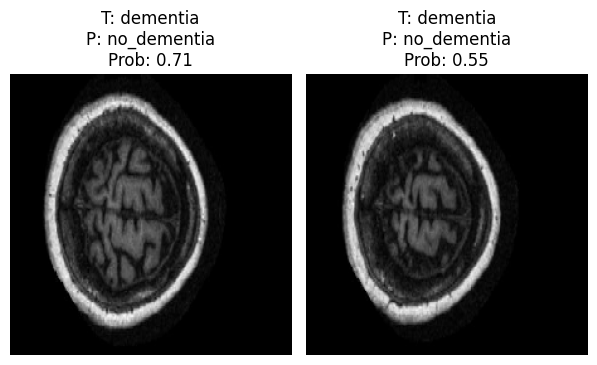

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Tomamos un batch del generador de test
test_gen.reset()
x_batch, y_batch = next(test_gen)

# Predicciones del modelo para ese batch
y_prob_batch = model.predict(x_batch).ravel()
y_pred_batch = (y_prob_batch >= 0.5).astype(int)

# Diccionario id -> nombre de clase
class_indices = test_gen.class_indices          # p.ej. {'no_dementia': 0, 'dementia': 1}
inv_class_indices = {v: k for k, v in class_indices.items()}

n_imgs = min(8, x_batch.shape[0])

plt.figure(figsize=(12, 8))
for i in range(n_imgs):
    plt.subplot(2, 4, i + 1)

    # Deshacer parcialmente el preprocess_input de VGG16 para visualizar
    img = x_batch[i].copy()
    img[..., 0] += 103.939
    img[..., 1] += 116.779
    img[..., 2] += 123.68
    img = np.clip(img / 255.0, 0, 1)

    plt.imshow(img)

    true_id = int(y_batch[i])
    pred_id = int(y_pred_batch[i])

    true_label = inv_class_indices.get(true_id, f"clase {true_id}")
    pred_label = inv_class_indices.get(pred_id, f"clase {pred_id}")

    plt.title(f"T: {true_label}\nP: {pred_label}\nProb: {y_prob_batch[i]:.2f}")
    plt.axis("off")

plt.tight_layout()
plt.show()
